---
title: LWD Tirol Meteo Download Package
date: 2025-04-08
categories: [python-package, data-download]
image: "sd-crop.png"
description: "Python package for downloading meteorological data of stations by the Avalanche Warning Service of Tyrol"
---


The package `lwdmeteo` is meant to facilitate download of meteorological data from the Avalanche Warning Service of Tyrol (Lawinenwarndienst Tirol, LWD Tirol). The package allows to retrieve a file (via `get_station_file()`) that contains all stations with some basic metadata which allows to explore when measurements start and what the corresponding station identifier (`lwd-nummer`) is. This station id must be passed to the actual download function (`download_station(...)`).

On the side of LWD Tirol, the files can be downloaded [here](https://lawinen.report/weather/archive) for a specific station, variable and [hydrological year](https://en.wikipedia.org/wiki/Water_year). The `lwdmeteo` package simply sends requests to very same url that is accessed when downloading files via this page. Note that the data is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

::: {.callout-warning}
The data available for download seems to be "raw" data and therefore should be carefully evaluated.
:::

For the purpose of visualization, in the following I will use Sep. 1 as the start of the "hydrological" year, as I think it is a bit nicer since it captures snowfall events early in the season. Therefore I "define" the hydrological year in the following starting Sep. 1 which does not adhere to the actual definition.


[{{< bi gitlab >}} Link to Gitlab Repo](https://git.uibk.ac.at/rslab/lwdmeteo)

In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
import lwdmeteo
from lwdmeteo import download_station, get_station_file, parameters

print(sys.version)
print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(mpl.__version__)
print(cx.__version__)
print(lwdmeteo.__version__)

3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
2.2.3
1.26.4
0.13.2
3.10.0
1.6.2
0.0.1


### Exploring available parameters
The keys of the dictionary are used to specify the desired parameter in the download function.

In [2]:
parameters

{'LT': 'Lufttemperatur',
 'LF': 'Luftfeuchte',
 'WG': 'Windgeschwindigkeit',
 'WR': 'Windrichtung',
 'GS': 'Globalstrahlung von oben',
 'HS': 'Schneehoehe',
 'T0': 'Oberflächentemperatur',
 'TP': 'Taupunkttemperatur',
 'WG.Boe': 'Windböe',
 'GS.unten': 'reflektierte Globalstrahlung'}

### Exploring available stations

In [3]:
gdf_stations = get_station_file()
gdf_stations.head()

,name,operator,lwd-nummer,begin,altitude,geometry
0,Schaufeljoch,LWD Tirol,NSGS1,2012,3160.0,POINT (11.1109 46.9772)
1,Lämmerbichlalm,LWD Tirol,TLAE2,1994,2020.0,POINT (11.75172 47.18127)
2,Schwarze Schneid,LWD Tirol,SRET1,1999,3370.0,POINT (10.92866 46.92399)
3,Adamsberg,LWD Tirol,GADA2,2000,2431.0,POINT (10.19016 46.98478)
4,Hafelekar,LWD Tirol,ISEE1,1993,2270.0,POINT (11.38362 47.31208)


### Visualization of station locations

Note that `get_station_file()` parses the response from [here](https://wiski.tirol.gv.at/lawine/produkte/ogd.geojson). This means that the following plot could look different if there are any updates in the future.

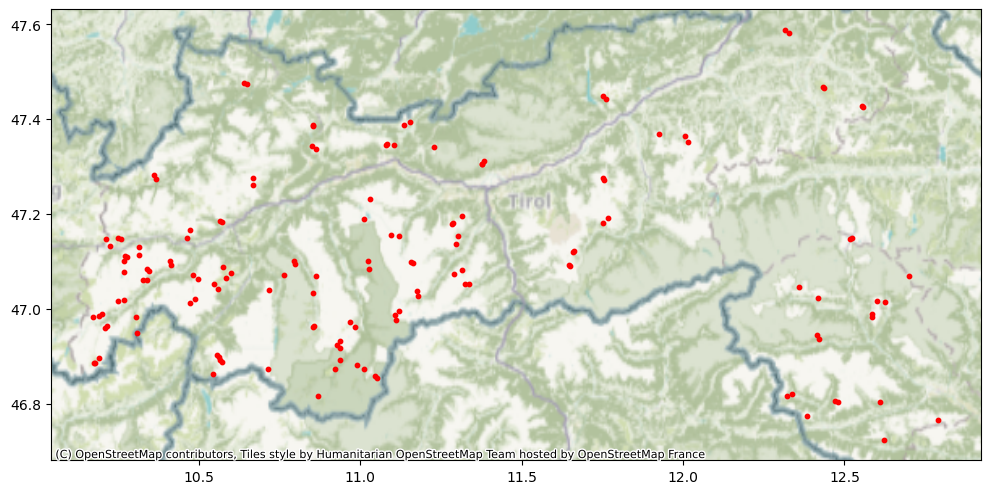

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf_stations.plot(ax=ax, color="r", markersize=10)
cx.add_basemap(ax, crs=gdf_stations.crs)

plt.show()

### Select station and retrieve measurement start

In [5]:
station = "LPUI2"  # Puitegg

gdf = get_station_file()
gdf.loc[gdf["lwd-nummer"] == station]

,name,operator,lwd-nummer,begin,altitude,geometry
120,Puitegg,LWD Tirol,LPUI2,2002,1539.0,POINT (11.15282 47.39484)


### Let's download the entire timeseries

In [6]:
#| output: false

parameter = "HS"  # snow depth

start_year = 2002
end_year = 2025

dfs = []

for year in range(start_year, end_year + 1):
    df = download_station(station, parameter, year)
    dfs.append(df)

df = pd.concat(dfs).sort_index()

# remove nans and drop duplicate timestamps
df = df.dropna()
df = df.loc[~df.index.duplicated(keep="first")]

In [7]:
df = df.resample("1D").mean()

# add hydrological year to df
df["hydro_year"] = df.index.to_series().dt.year + (df.index.to_series().dt.month >= 9)

### Some (maybe overly complicated?) method to add the day-of-year starting september first

In [8]:
df["hydro_doy"] = df.index.to_series().dt.day_of_year
doy_values = np.copy(df.index.to_series().dt.day_of_year.values)

break_value = (
    244 + df.index.to_series().dt.is_leap_year
)  # DOY of Sep. 1 minus 1 day; in leap years Sep. 1
minus = break_value - 1
plus = 122  # nr of days after Sep. 1 - same every year

df.loc[doy_values >= break_value, "hydro_doy"] = (
    df.loc[doy_values >= break_value, "hydro_doy"] - minus
)
df.loc[doy_values < break_value, "hydro_doy"] = (
    df.loc[doy_values < break_value, "hydro_doy"] + plus
)

### Clean up 

* Set values above 1 m snow depth in July and August to nan, as I assume these are measurement errors
* Remove 2013, 2014 and 2015, it seems the data contains erroneous values in these years (not shown here)

In [9]:
cond = (
    (df.index.to_series().dt.month < 9)
    & (df.index.to_series().dt.month > 6)
    & (df["HS"] > 100)
)
df.loc[cond, "HS"] = np.nan

df = df.loc[~df["hydro_year"].isin([2013, 2014, 2015])]

Compute percentiles to be added to the plots as additional info
(can be easily exchanged for min/max or other metrics)

In [10]:
# | code-fold: true

min_max = (
    df.groupby("hydro_doy")[["HS"]]
    .agg(
        min=("HS", lambda x: np.nanpercentile(x, 5)),
        max=("HS", lambda x: np.nanpercentile(x, 95)),
        med=("HS", lambda x: np.nanmedian(x)),
    )
    .reset_index()
)

Add upper and lower bounds of entire timeseries to original data frame for easier access

In [11]:
df_merged = df.merge(min_max, on="hydro_doy", suffixes=("", "_global"))
df_merged.head()

,HS,hydro_year,hydro_doy,min,max,med
0,0.000000,2003,33,-3.581250,19.069733,6.093536
1,0.194444,2003,34,-2.737500,18.760327,5.895833
2,0.305556,2003,35,-1.600694,18.482539,7.243056
3,0.805556,2003,36,-2.391667,20.547516,8.152778
4,0.847222,2003,37,-3.656250,21.091667,9.930556


### Visualize

Titles specify the "hydrological year" starting Sep. 1.

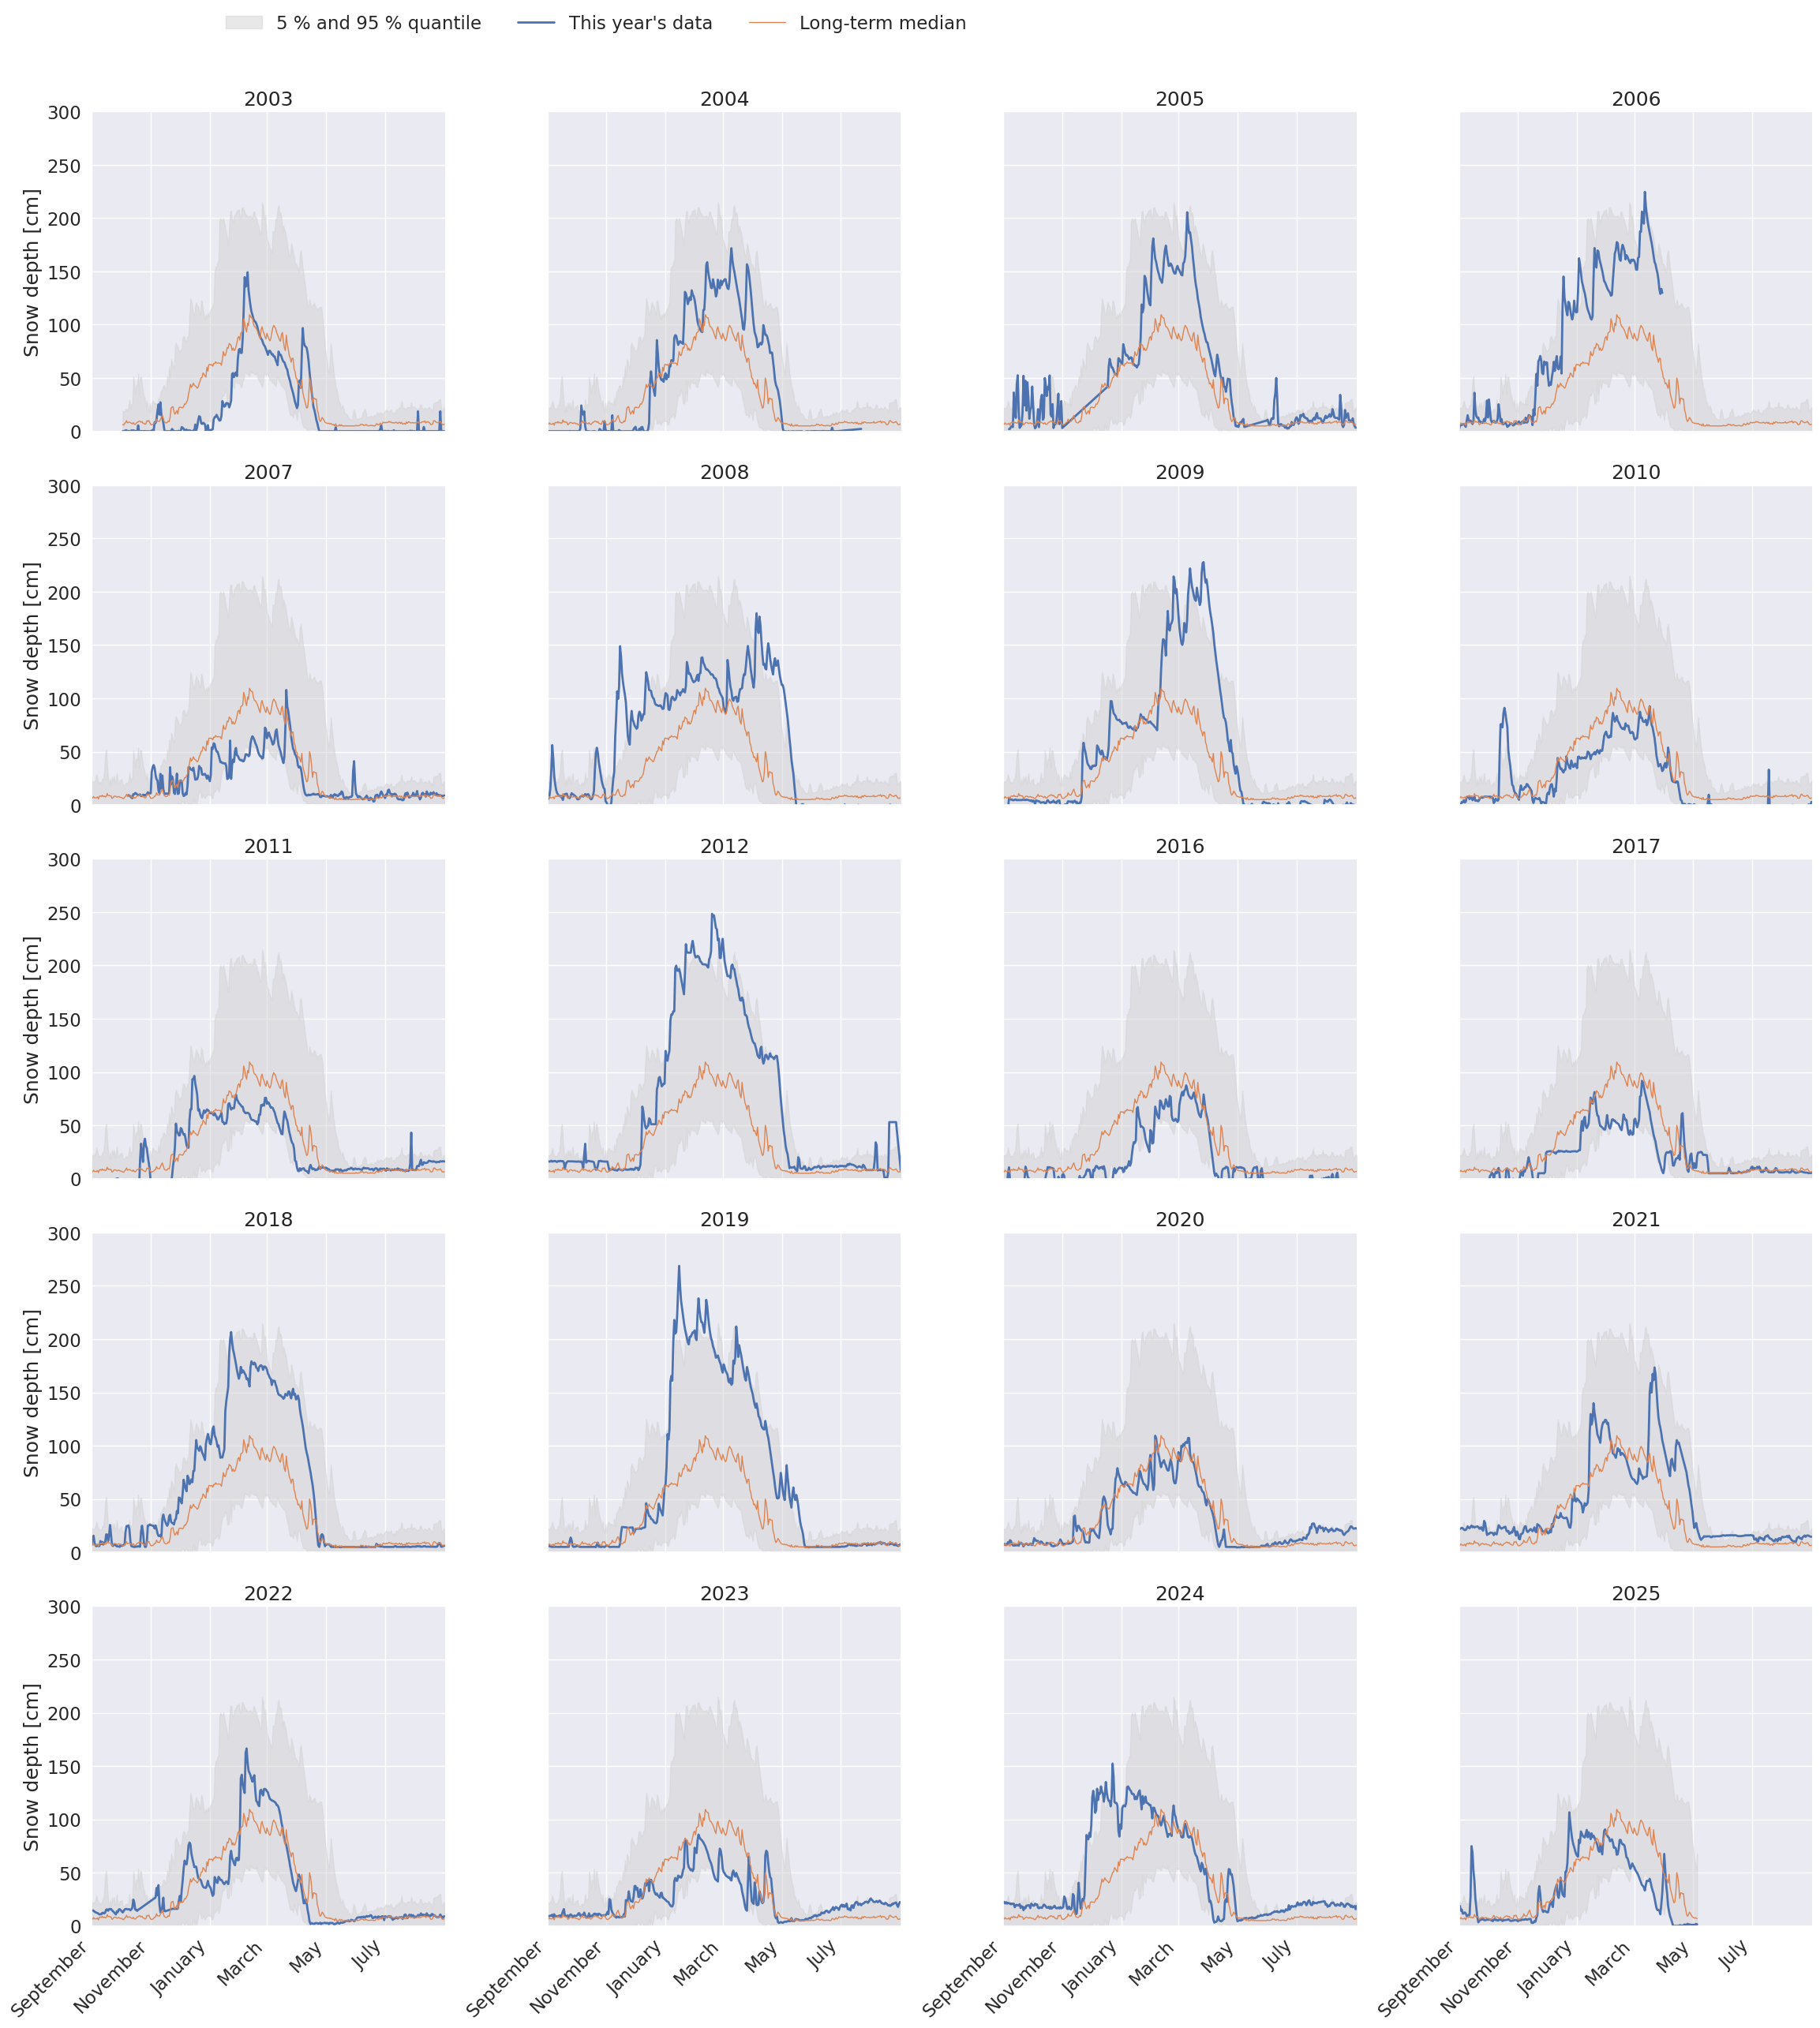

In [12]:
# | code-fold: true

# generate ticklabels
dates_x = pd.date_range(start="2021-09-01", end="2022-08-31", freq="2MS")
ticklabels = dates_x.to_series().dt.strftime("%B").values
tickpos = dates_x.to_series().dt.day_of_year.values
dayvals = tickpos.copy()

tickpos[dayvals >= 244] = tickpos[dayvals >= 244] - 243
tickpos[dayvals < 244] = tickpos[dayvals < 244] + 122

sns.set_theme(font_scale=1.5)

g = sns.FacetGrid(
    df_merged,
    col="hydro_year",
    col_wrap=4,
    sharey=True,
    sharex=True,
    height=5,
    aspect=1.2,
)


def plot_with_minmax(data, color, **kwargs):
    plt.fill_between(
        data["hydro_doy"],
        data["min"],
        data["max"],
        color="lightgrey",
        label="5 % and 95 % quantile",
        alpha=0.5,
    )

    sns.lineplot(
        data=data, x="hydro_doy", y="HS", linewidth=2, label=f"This year's data"
    )
    sns.lineplot(
        data=data, x="hydro_doy", y="med", linewidth=1, label="Long-term median"
    )
    plt.title(data["hydro_year"].iloc[0])


g.map_dataframe(plot_with_minmax)


def set_lim_label(color, xmin, xmax, ymax):
    ax = plt.gca()

    ax.set_xticks(tickpos, ticklabels, rotation=45, ha="right")

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((0, ymax))
    ax.set_ylabel("Snow depth [cm]")
    ax.set_xlabel(None)


g.map(set_lim_label, xmin=1, xmax=366, ymax=300)

g.add_legend(loc="lower left", bbox_to_anchor=(0.1, 1.01), ncol=3)

plt.savefig(f"{station}-snow-depth.png", dpi=100, bbox_inches="tight")
plt.show()